## Classificador binário para características morfométricas de núcleo/citoplasma de células cervicais 

In [149]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import feature_selection as fs

# pay attention to capitalization below!
from spFSR import SpFSR

from itertools import cycle

from random import randint
from random import sample

import xgboost as xgb 

import csv

In [150]:
IMG_W = 1376
IMG_H = 1020
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 
PATH_masks = "D:/baseCRIC/SegmentacaoCriC/mascaras" 

In [151]:
# Extra cell_id de núcleo/citoplasma
def list_cells(nucleos_csv, cyto_csv): 
   df_nucleos_full = pd.read_csv(nucleos_csv, header=0)
   df_cyto_full = pd.read_csv(cyto_csv, header = 0)
   
   # dataframe of unique cells (nucleos)
   df_nucleos = df_nucleos_full[['image_id', 'cell_id']]
   df_nucleos = df_nucleos.sort_values(by=['image_id', 'cell_id']) 
   df_nucleos = df_nucleos.drop_duplicates(subset=['image_id', 'cell_id'], keep='first', inplace=False) 
    
   # dataframe of unique cells (cytoplams)
   df_cyto = df_cyto_full[['image_id', 'cell_id']]
   df_cyto = df_cyto.sort_values(by=['image_id', 'cell_id']) 
   df_cyto= df_cyto.drop_duplicates(keep='first', inplace=False) 
    
   return (df_nucleos, df_cyto,df_nucleos_full, df_cyto_full)


### Funções para extração de features - shape e contorno:

In [152]:
# Calcula localização relativa do núcleo dentro do citoplasma (versão Daniela):
'''def nucleus_to_cyto_border_dist(cent_N, cent_C, border_coords_C, border_coords_N):
    dists_bound_C= cdist(border_coords_C, list([cent_N]), metric='euclidean') 
    dist_bound_C = np.min(dists_bound_C)
    nearest_point = border_coords_C[np.argmin(dists_bound_C)]
    
    dists_bounds_N_to_C = cdist(border_coords_N, list([nearest_point]), metric='euclidean')
    dist_bounds_N_to_C = np.min(dists_bounds_N_to_C)
    
    #print(nearest_point)
    normal_dist = np.sqrt((nearest_point[0]- cent_C[0])**2 + (nearest_point[1]- cent_C[1])**2)
    #print('dist C: ', normal_dist)
    return dist_bounds_N_to_C/normal_dist
    '''

# Calcula localização relativa do núcleo dentro do citoplasma (versão \cite{Mariarputham2015}):
def nucleus_position(cent_N, cent_C, minAxC):
    d = np.sqrt((cent_N[0]-cent_C[0])**2 + (cent_N[1]-cent_C[1])**2)
    if d == 0:
        return 0
    else: 
        return (d/minAxC)  #distância entre os centroides (N - C)/eixo menor do citoplasma

## Para chamada ao metodo que approxima o contorno com a série de Fourier series, como descrito em (https://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/Kuhl-Giardina-CGIP1982.pdf)
## Fonte: https://pyefd.readthedocs.io/en/latest/#second
def efd_feature(contour, n_coeffs):
    '''  contour: pontos de borda
         n_coeffs: nº de coeficientes da serie de fourier (X(sen e cos) para Y(sen e cos))
         retorno: tupla (coeficientes, número de coeficientes)
    ''' 
    coeffs = elliptic_fourier_descriptors(contour, order= n_coeffs, normalize=True)
    return (coeffs.flatten()[3:(n_coeffs*4+1)], (n_coeffs*4+1 - 3))

# Calcula Dimensão Fractal
# From: https://github.com/jankaWIS/fractal_dimension_analysis/blob/main/fractal_analysis_fxns.py
def fractal_dimension(Z, threshold=0.9):
    """
    calculate fractal dimension of an object in an array defined to be above certain threshold as a count of squares
    with both black and white pixels for a sequence of square sizes. The dimension is the a coefficient to a poly fit
    to log(count) vs log(size) as defined in the sources.
    :param Z: np.array, must be 2D
    :param threshold: float, a thr to distinguish background from foreground and pick up the shape, originally from
    (0, 1) for a scaled arr but can be any number, generates boolean array
    :return: coefficients to the poly fit, fractal dimension of a shape in the given arr
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def boxcount(Z, k):
    """
    returns a count of squares of size kxk in which there are both colours (black and white), ie. the sum of numbers
    in those squares is not 0 or k^2
    Z: np.array, matrix to be checked, needs to be 2D
    k: int, size of a square
    """
    S = np.add.reduceat(
        np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)  # jumps by powers of 2 squares

    # We count non-empty (0) and non-full boxes (k*k)
    #return len(np.where((S > 0) & (S < k * k))[0])
    return len(np.where(S > 0)[0])


# Calcula o alongamento da célula a partir da sua bounding box:
def elongation(bbox):
     l = (bbox[2] - bbox[0])  # maxRow - minRow 
     w = (bbox[3] - bbox[1])  # maxCol - minCol
     return (1 - (w/l))


#Calcula as distâncias radiais (algumas métricas de \cite{Po-HsiangTsui2010a, e \cite{Chiang2001} para CA de mama})
def radial_distances_stats(centroid, border_coords):
    ''' Retorna:
        desvio padrão da distancia radial (SDNRL)
        tx de área: porcentagem de area fora da distância radial média
        RI: indice de rugosidade
        E : entropia do histograma do comprimento radial normalizado representa a redondeza e a rugosidade.
        k: kurtosis do histograma das 
        MRD: comprimento radial máximo (maximum length from center of gravity to perimeter) - valores absolutos (não normalizados)
        ARD: comprimento radial médio (average length from center of gravity to perimeter) - valores absolutos (não normalizados)
    '''    
    dis= cdist(border_coords, list([centroid]), metric='euclidean') 
    dis_Norm = dis/np.max(dis)
    mean = np.mean(dis_Norm)
    SDNRL= np.std(dis_Norm, ddof=1) 
    
    # Calcula taxa de area, soma di - dis[i+1]:
    N = dis_Norm.shape[0]
    area_out = 0
    sum = 0
    for i in range(N):
        if dis_Norm[i] >=mean: 
           area_out +=(dis_Norm[i] - mean)   
        if i != (N-1):
            sum += np.abs(dis_Norm[i] - dis_Norm[i+1])
    RA = area_out /(N*mean)
    
    # Calcula índice de rugosidade(RI):
    RI = sum/N
    
    # Calcula a entropia (E) do histograma dis_Norm
    hist, _ = np.histogram(dis, bins=100, density=True, )
    E = 0
    for p in hist: 
       if p!= 0:
          E+=(p*np.log(p))
    K = kurtosis(dis)   
    return ({'SDNRL': SDNRL, 'RA': RA[0], 'RI': RI[0], 'E':-E, 'K': K, 'MRD': np.max(dis), 'ARD': np.mean(dis)})


In [153]:
def get_list_feature_labels(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   
   efdNs = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdNs:
       feature_labels.append(name_f) 
   
   aux=['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 
   for name_f in aux:
       feature_labels.append(name_f)

   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
    
   aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']

   for name_f in aux:
       feature_labels.append(name_f)
   return feature_labels   

def create_dictionary_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
   feature_labels=['image_id', 'cell_id']
   features = get_list_feature_labels(n_efd_coeffs)
   for name in features:
      feature_labels.append(name)
        
   feature_labels.append('bethesda')     

   aux = [[] for i in range(len(feature_labels))]
   return dict(zip(feature_labels, aux))

def set_efd_coeff(coeffs, dictio, efd='N'):
    if efd == 'N':
       efds = ['efdN'+str(i) for i in range(1, coeffs.shape[0]+ 1)] 
    else:
       efds = ['efdC'+str(i) for i in range(1, coeffs.shape[0]+ 1)] 
    for feat, value in zip(efds, coeffs):
        dictio[feat].append(value)

##### Gera dataframe de features: 120 features de formato e contorno para nucleo (N) e citoplasma (C)


In [154]:
# Para cada célula (identificação e features)
# Calula, registra e retorna dataframe de 120 features de formato e contorno para nucleo (N) e citoplasma (C)
def make_stats(df_nucleos, df_cyto, df_nucleos_full, df_cyto_full, n_efd_coeffs= 10):
   """ 
     Features (N e C):  
           area, excentricidade, extenção, perímetro, major Axis, minor Axis,
           compacidade, circularidade, convexidade, area do convex hull', solidicidade, 
           diâmetro equivalente, alongamento, SDNRL, RA, RI, entropia das distâncias radiais (RD),
           kurtosis das distâncias radiais, maior RD, average RD, FD (dimensão fractal), 
           'n_efd_coeffs' 1º coeficientes da série EF (elliptic fourier descriptor)
     Features relação N/C: razão area N/C, razão perimetro N/C,razão area convex hull N/C, posição relativa do nucleo
     
   """ 
   count_cells = np.zeros(6, dtype = int)
    
   data = create_dictionary_features(n_efd_coeffs)
   for image_id, cell_id in df_nucleos.values:   
        cell = f'{image_id:05d}_{cell_id:05d}_'
        
        points_nucleos = df_nucleos_full.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))[['x', 'y']].values
        points_cyto = df_cyto_full.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))[['x', 'y']].values
        bethesda = Bethesda_classes[df_nucleos_full.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))['bethesda_system'].values[0]]
                
        # Nucleos mask
        mask_nucleo =  np.zeros((IMG_H, IMG_W), dtype=np.uint8)
        # Cytoplasma mask
        mask_cyto =  np.zeros((IMG_H, IMG_W), dtype=np.uint8)
        
        # Nucleos contour points
        rrN, ccN = polygon(points_nucleos[:,1], points_nucleos[:,0])
        mask_nucleo[rrN, ccN] = 1    
        
        # Cytoplasm contour points
        rrC, ccC = polygon(points_cyto[:,1], points_cyto[:,0])
        mask_cyto[rrC, ccC] = 1    
        
        # Eliminate duplicate contour points: 
        border_coords_N = [[ri, ci] for ri,ci in zip(rrN, ccN)]
        border_coords_C = [[ri, ci] for ri,ci in zip(rrC, ccC)]
        points_N = np.array(border_coords_N, dtype=np.float64)
        points_N = np.unique(points_N, axis=0)
        points_C = np.array(border_coords_C, dtype=np.float64)
        points_C = np.unique(points_C, axis=0)
           
        # Calc regionprops metrics from Nucleos mask:
        m_N = measure.regionprops(mask_nucleo)  
        
        # Calc regionprops metrics from Cyto mask:
        m_C = measure.regionprops(mask_cyto)
 
        # Get metrics:
        area_N = m_N[0].area
        eccenN = m_N[0].eccentricity 
        extentN = m_N[0].extent   # area / area da bounding box (bbox)
        per_N = m_N[0].perimeter
        max_N = m_N[0].axis_major_length
        min_N = m_N[0].axis_minor_length 
        cent_N = m_N[0].centroid
        compacN = np.power(per_N,2)/area_N    # perimetro^2/area
        circulN = (4*np.pi*area_N)/np.power(per_N,2)    # 4pi*area/perimetro^2
        convexN = measure.perimeter(m_N[0].image_convex)/per_N  #  perimetro do convex hull/perimetro
        hAreaN = m_N[0].area_convex 
        solidN =  m_N[0].solidity  # area / area do convex hull
        equidiaN  = m_N[0].equivalent_diameter_area # diametro equivalente de um círculo de mesma area
        elonN = elongation(m_N[0].bbox)  # (1 - w/L), onde w é a largura em colunas da bbox e L a altura da bbox
        rdN= radial_distances_stats(cent_N, points_N) # estatísticas de distancia radial (centroid borda) p/ Nucleo
        
        area_C = (m_C[0].area - area_N)
        eccenC = m_C[0].eccentricity
        extentC = m_C[0].extent
        per_C = m_C[0].perimeter
        max_C = m_C[0].axis_major_length
        min_C = m_C[0].axis_minor_length 
        cent_C = m_C[0].centroid
        compacC = np.power(per_C,2)/area_C
        convexC = measure.perimeter(m_C[0].image_convex)/per_C
        circulC = (4*np.pi*area_C)/np.power(per_C,2)
        hAreaC = m_C[0].area_convex
        solidC =  m_C[0].solidity
        equidiaC  = m_C[0].equivalent_diameter_area
        elonC = elongation(m_C[0].bbox)
        rdC= radial_distances_stats(cent_C, points_C) # estatísticas de distancia radial (centroid borda) p/ Cito
    
        # Calcula posição relativa do núcleo no citoplasma
        nucleus_pos= nucleus_position(cent_N, cent_C, min_C)
    
        #Calc rations to nucleus and cytoplasm areas 
        ratio_NC = area_N/area_C
        ratio_NC_per = per_N/per_C
        ratio_NC_hArea = hAreaN/hAreaC

        # Registry metrics on data dict:
        data['image_id'].append(image_id)
        data['cell_id'].append(cell_id)
        data['areaN'].append(area_N)
        data['eccenN'].append(eccenN)
        data['extentN'].append(extentN) 
        data['periN'].append(per_N)
        data['maxAxN'].append(max_N)
        data['minAxN'].append(min_N)
        data['compacN'].append(compacN)
        data['circuN'].append(circulN)
        data['convexN'].append(convexN)
        data['hAreaN'].append(hAreaN)
        data['solidN'].append(solidN) 
        data['equidiaN'].append(equidiaN)
        data['elonN'].append(elonN) 
        data['sdnrlN'].append(rdN['SDNRL'])
        data['raN'].append(rdN['RA'])
        data['riN'].append(rdN['RI'])
        data['eN'].append(rdN['E'])
        data['kN'].append(rdN['K'])
        data['mrdN'].append(rdN['MRD'])
        data['ardN'].append(rdN['ARD'])
        data['fdN'].append(fractal_dimension(mask_nucleo))
        efd_coeffs_N, _ = efd_feature(points_N, n_efd_coeffs)
        set_efd_coeff(efd_coeffs_N, data)
            
        data['areaC'].append(area_C)
        data['eccenC'].append(eccenC)
        data['extentC'].append(extentC) 
        data['periC'].append(per_C)
        data['maxAxC'].append(max_C)
        data['minAxC'].append(min_C)
        data['compacC'].append(compacC)
        data['circuC'].append(circulC)
        data['convexC'].append(convexC)
        data['hAreaC'].append(hAreaC)
        data['solidC'].append(solidC)
        data['equidiaC'].append(equidiaC)
        data['elonC'].append(elonC)
        data['sdnrlC'].append(rdC['SDNRL'])
        data['raC'].append(rdC['RA'])
        data['riC'].append(rdC['RI'])
        data['eC'].append(rdC['E'])
        data['kC'].append(rdC['K'])
        data['mrdC'].append(rdC['MRD'])
        data['ardC'].append(rdC['ARD'])
        data['fdC'].append(fractal_dimension(mask_cyto))        
        efd_coeffs_C, _ = efd_feature(points_C, n_efd_coeffs)
        set_efd_coeff(efd_coeffs_C, data, efd='C')         
        
        data['ratio_NC'].append(ratio_NC)
        data['ratio_NC_per'].append(ratio_NC_per)
        data['ratio_NC_hArea'].append(ratio_NC_hArea)
        data['nucleus_position'].append(nucleus_pos)
    
        data['bethesda'].append(bethesda)
        
        count_cells[bethesda]+=1
        
   df = pd.DataFrame(data)
   return (count_cells, df)  
 

In [155]:
## Normaliza dados
def normalize(min, max, value):
    return (value-min)/(max - min)

def normalize_prop(prop, df):
    min = np.min(df[prop].values)
    max = np.max(df[prop].values)
    return (normalize(min, max, df[prop].values))

In [156]:
# Filtra/normaliza dados
def normalize_dataset(df, n_efd_coeffs):
  dataset = df.copy()
   
  dataset.areaN = normalize_prop('areaN', df)
  dataset.eccenN = normalize_prop('eccenN', df) 
  dataset.extentN = normalize_prop('extentN', df)
  dataset.periN = normalize_prop('periN', df)
  dataset.maxAxN = normalize_prop('maxAxN', df)  
  dataset.minAxN = normalize_prop('minAxN', df)  
  dataset.compacN = normalize_prop('compacN', df)
  dataset.circuN = normalize_prop('circuN', df)
  dataset.convexN = normalize_prop('convexN', df)
  dataset.hAreaN = normalize_prop('hAreaN', df)
  dataset.solidN = normalize_prop('solidN', df) 
  dataset.equidiaN = normalize_prop('equidiaN', df) 
  dataset.elonN = normalize_prop('elonN', df)
  dataset.eN = normalize_prop('eN', df)  
  dataset.kN = normalize_prop('kN', df)  
  dataset.mrdN = normalize_prop('mrdN', df)  
  dataset.ardN = normalize_prop('ardN', df)  
  dataset.fdN = normalize_prop('fdN', df)       
  efds = ['efdN'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df) 
    
  dataset.areaC = normalize_prop('areaC', df)
  dataset.eccenC = normalize_prop('eccenC', df) 
  dataset.extentC = normalize_prop('extentC', df)
  dataset.periC = normalize_prop('periC', df)
  dataset.maxAxC = normalize_prop('maxAxC', df)  
  dataset.minAxC = normalize_prop('minAxC', df)
  dataset.compacC = normalize_prop('compacC', df)
  dataset.circuC = normalize_prop('circuC', df)
  dataset.convexC = normalize_prop('convexC', df)
  dataset.hAreaC = normalize_prop('hAreaC', df)
  dataset.solidC = normalize_prop('solidC', df) 
  dataset.equidiaC = normalize_prop('equidiaC', df) 
  dataset.elonC = normalize_prop('elonC', df)
  dataset.eC = normalize_prop('eC', df)  
  dataset.kC = normalize_prop('kC', df)  
  dataset.mrdC = normalize_prop('mrdC', df)  
  dataset.ardC = normalize_prop('ardC', df)  
  dataset.fdC = normalize_prop('fdC', df)       
  efds = ['efdC'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df)   

  #dataset.nucleus_position = normalize_prop('nucleus_position', df)
 
  return dataset

### Funções para classificadores e métricas

In [157]:
# Executa e retorna a predição do modelo KNN:
def execute_KNN(data_train, target_train, data_test, n_nbors):     
        model_knn = KNeighborsClassifier(n_neighbors= n_nbors)      ## instancia
        model_knn.fit(data_train, target_train)                     ## treino 
        target_prediction = model_knn.predict(data_test)            ## teste  
        return target_prediction
    
# Executa e retorna a predição para SVM:
def execute_SVM(data_train, target_train, data_test, kn='rbf', degr=3):     
        model_svm = SVC(kernel= kn, degree=degr) 
        model_svm.fit(data_train, target_train)
        target_pred = model_svm.predict(data_test)
        return target_pred
    
# Executa e retorna a predição para Naive:
def execute_NB(data_train, target_train, data_test): 
       model_nb = GaussianNB()
       model_nb.fit(data_train, target_train)
       return model_nb.predict(data_test)
              
# Gera modelo RandomForest
def fit_get_RF(data_train, target_train): 
    model =RandomForestClassifier()
    model.fit(data_train, target_train)
    return model

def getModel(classifier = 'SVM', class_type = 'binary'):
    if classifier == 'SVM':
        model = SVC(kernel= 'rbf', degree=3, probability=True) 
    elif classifier == 'RF':
        model =RandomForestClassifier()
    elif classifier == 'XGBoost':
        if class_type == 'binary':
           #model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
           model = xgb.XGBClassifier(
                     learning_rate =0.25,
                     n_estimators=500,
                     max_depth=7,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     reg_alpha=0.05,
                     objective= 'binary:logistic',
                     scale_pos_weight=1,
                     seed=27)
        else:    # multiclass  
            #model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
            model = xgb.XGBClassifier(
                     learning_rate= 0.25,
                     n_estimators=500,
                     max_depth=7,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     reg_alpha=0.05,
                     objective= 'multi:softprob',
                     seed=27)
    else:
        model = None # 'MLP toDo'    
    return model    
    

# Calcula métricas: (vide metrics_type e classifiers_type)
def calc_metric(target_test, target_predict, metric_type='acc', class_type ='binary', classes=[0,1]):   
    if (metric_type == 'acc'):
        return accuracy_score(target_test, target_predict)
    elif (metric_type == 'prec'):
         if (class_type == 'binary'):  ## caso classificadores binário
            return  precision_score(target_test, target_predict, zero_division=0)  
         else:  ## multiclasses
            return precision_score(target_test, target_predict, average='weighted', zero_division=0)
    elif (metric_type == 'rec'):
        if (class_type == 'binary'):  ## classificadores binários
            return recall_score(target_test, target_predict, zero_division=0)
        else:  ## multiclasses
            return  recall_score(target_test, target_predict, average ='weighted', zero_division=0)
    elif (metric_type == 'spec'):   
         if (class_type == 'binary'):  ## classificadores binários
            tn, fp, fn, tp = confusion_matrix(target_test, target_predict).ravel()
            return tn/(tn + fp)
         else:  ##  multiclasses - média aritmética  
            spec = 0
            for l in classes:
                tn, fp, fn, tp = confusion_matrix((np.array(target_test)==l), (np.array(target_predict)==l)).ravel()
                spec += tn/(tn + fp)
            return spec/len(classes)  
    elif (metric_type == 'f1_score'):      
         if (class_type == 'binary'):  ## classificadores binários
            f1 = f1_score(target_test, target_predict)
            return f1
         else:  ## multiclasses
            f1 = f1_score(target_test, target_predict, average= 'weighted')
            return f1 
    else:
        return None

def fill_line_metrics(model_name, featur, target, pred, line_results, class_type='binary', pos_lb=1):
    accur = calc_metric(target, pred, 'acc', class_type)
    prec = calc_metric(target, pred, 'prec', class_type, pos_lbl= pos_lb)
    sens = calc_metric(target, pred, 'sens', class_type)
    espe = calc_metric(target, pred, 'espec', class_type)
    f1Mes = calc_metric(target, pred, 'f1_mesure', class_type, pos_lbl= pos_lb)

    line = pd.Series(data = np.array([class_type, model_name, featur,
                        '{:.4f}'.format(accur), '{:.4f}'.format(prec), '{:.4f}'.format(sens),
                        '{:.4f}'.format((1- espe)), '{:.4f}'.format(espe), '{:.4f}'.format(f1Mes)], dtype = object), 
                index=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure']) 
    results.loc[line_results] = line

def fill_line_metrics_CV(model_name, featur, line_results, metrics, results, class_type='binary'):
    line = pd.Series(data = np.array([class_type, model_name, featur,
             '{:.4f}'.format(metrics['acc']), '{:.4f}'.format(metrics['prec']),
             '{:.4f}'.format(metrics['rec']),'{:.4f}'.format((1- metrics['spec'])), 
             '{:.4f}'.format(metrics['spec']), '{:.4f}'.format(metrics['f1_score'])], dtype = object), 
              index=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 
                     'Falso Pos', 'Especif', 'F1_measure']) 
    results.loc[line_results] = line
    
    
def plot_roc_curve(roc_curve_list, labels_list):
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    for i,color in zip(range(len(roc_curve_list)), colors):
        plt.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            lw=2,
            label= labels_list[i],
        )
    plt.plot([0, 1] , c=".7", ls="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Normal vs anormal Random Forest) ')
    plt.legend(fontsize= 'medium')
    plt.show()
 

## Plota gráfico de ganho para features selecionadas: 
def plot_imp(best_features_1, scores_1, method_name_1,
            best_features_2, scores_2, method_name_2):   
    
    plt.style.use("bmh")
    #plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
    axs[0].tick_params(labelsize= 'small')
    axs[0].barh(best_features_1, scores_1, color= 'blue', height=0.75)    
    axs[0].set(xlim=[min(0, (np.min(scores_1))), max(0.8, np.max(scores_1)+0.1)], xlabel='Score', ylabel='Feature', title= method_name_1 + ' Scores')
    axs[1].tick_params(labelsize= 'small')
    axs[1].set(xlim=[min(0, np.min(scores_2)), max(0.8, np.max(scores_2)+0.1)], xlabel='Score', ylabel='Feature', title=method_name_2 + ' Scores')
    axs[1].barh(best_features_2, scores_2, color= 'green')    
    
    #fig.suptitle('Feature Selection') 
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
    plt.show()

# Gera grafico matriz confusao  
def make_confusionMatrixDisplay(test, pred, labels, title):
    cm = confusion_matrix(test, pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return (disp, title)
 


### Classificador Normal vs Anormal(ASC-US, ASC-H, LSIL, HSIL, Carcinoma)

#####  Filtra dados por classe

In [158]:
df_nucleos, df_cyto,df_nucleos_full, df_cyto_full = list_cells('./base/nucleus-segmentations.csv', './base/cytoplasm-segmentations.csv') 


In [159]:
N_EFD_COEFFS = 20

In [45]:

count_cells, dfAll = make_stats(df_nucleos, df_cyto, df_nucleos_full, df_cyto_full, n_efd_coeffs= N_EFD_COEFFS)


In [46]:
df = dfAll.copy()
df = df.astype('float64')
df.to_csv('dataCRIC.csv', sep = '|', index=False)

In [47]:
df.dtypes

image_id            float64
cell_id             float64
areaN               float64
eccenN              float64
extentN             float64
                     ...   
ratio_NC            float64
ratio_NC_per        float64
ratio_NC_hArea      float64
nucleus_position    float64
bethesda            float64
Length: 203, dtype: object

In [160]:
df = pd.read_csv('dataCRIC.csv', sep='|', header=0)
df = normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
 

In [161]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.156532,0.321490,0.859931,0.382225,0.302311,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.150931,0.317850,0.859539,0.369221,0.299938,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.153458,0.315454,0.861978,0.367980,0.302076,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.157254,0.319562,0.860312,0.382943,0.303682,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.147193,0.314554,0.860292,0.359672,0.300094,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.152113,0.318217,0.859606,0.370535,0.299400,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.150010,0.322108,0.859366,0.375599,0.300755,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.153944,0.319972,0.860379,0.372458,0.303245,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.151898,0.320620,0.859608,0.370771,0.299599,0.111823,0.078186,0.023058,3.177247,5.0


In [162]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


#### Separa dados para classificação binária (normal vs anormal):

In [163]:
# Lista para filtro de FEATURES para o modelo:
features_all = get_list_feature_labels(N_EFD_COEFFS)

features_all_desc = 'All metrics'
features_c = ['areaC', 'periC','maxAxC', 'minAxC','compacC', 'circuC', 'convexC', 'ratio_NC', 
              'ratio_NC_per', 'dist_to_border_c'] 
features_c_desc = 'Cyto metrics,ratios N/C, dist'
features_n = ['areaN', 'periN','maxAxN', 'minAxN','compacN', 'circuN', 'convexN',  'ratio_NC', 
              'ratio_NC_per', 'dist_to_border_c'] 
features_n_desc = 'Nucleos metrics,ratios N/C, dist'

features_efdN = ['efdN'+str(i) for i in range(1,38)]
features_efdC = ['efdC'+str(i) for i in range(1,38)]
features_efd = features_efdN +  features_efdC


In [164]:
features = features_all
features_desc = features_all_desc 
print(f'Nº de features: {len(features)}\n', features)

Nº de features: 200
 ['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN', 'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN', 'efdN1', 'efdN2', 'efdN3', 'efdN4', 'efdN5', 'efdN6', 'efdN7', 'efdN8', 'efdN9', 'efdN10', 'efdN11', 'efdN12', 'efdN13', 'efdN14', 'efdN15', 'efdN16', 'efdN17', 'efdN18', 'efdN19', 'efdN20', 'efdN21', 'efdN22', 'efdN23', 'efdN24', 'efdN25', 'efdN26', 'efdN27', 'efdN28', 'efdN29', 'efdN30', 'efdN31', 'efdN32', 'efdN33', 'efdN34', 'efdN35', 'efdN36', 'efdN37', 'efdN38', 'efdN39', 'efdN40', 'efdN41', 'efdN42', 'efdN43', 'efdN44', 'efdN45', 'efdN46', 'efdN47', 'efdN48', 'efdN49', 'efdN50', 'efdN51', 'efdN52', 'efdN53', 'efdN54', 'efdN55', 'efdN56', 'efdN57', 'efdN58', 'efdN59', 'efdN60', 'efdN61', 'efdN62', 'efdN63', 'efdN64', 'efdN65', 'efdN66', 'efdN67', 'efdN68', 'efdN69', 'efdN70', 'efdN71', 'efdN72', 'efdN73', 'efdN74', 'efdN75', 'efdN76', 'efdN77', 'areaC', 'eccenC', 'extent

### Seleção de características:

In [165]:
N_FEATURES = 30   # number of selected features
df.shape, len(get_list_feature_labels(n_efd_coeffs=20))

((3233, 203), 200)

In [196]:
### FEATURES SELECTION: "Simultaneous Perturbation Stochastic Approximation (SPSA) for feature selection and ranking" 
# Fonte: An implementation of feature selection and ranking via SPSA based on the article "K-best feature selection and ranking via stochastic approximation"(https://www.sciencedirect.com/science/article/abs/pii/S0957417422018826) 
# Código: https://github.com/akmand/spFSR.git
def features_selection_spfsr(data_normal, data_ascus, data_lsil, data_asch, 
                             data_hsil,data_car, n_normal=(77*5), n_ascus=77,
                             n_lsil=77, n_asch=77, n_hsil=77, n_car=77, 
                             N_FEATURES = 20):

    # All features list (without coluns: 'image_id', 'cell_id', 'bethesda'):
    features = get_list_feature_labels(N_EFD_COEFFS) 
    data =  pd.DataFrame(data=np.vstack([
                                      data_normal.loc[sample(range(0, data_normal.shape[0]), n_normal)].values,
                                      data_ascus.loc[sample(range(0, data_ascus.shape[0]), n_ascus)].values,
                                      data_asch.loc[sample(range(0, data_asch.shape[0]), n_asch)].values,
                                      data_lsil.loc[sample(range(0, data_lsil.shape[0]), n_lsil)].values, 
                                      data_hsil.loc[sample(range(0, data_hsil.shape[0]), n_hsil)].values,
                                      data_car.loc[sample(range(0, data_car.shape[0]), n_car)].values]), 
                                     columns = data_car.columns) 
    data_x = np.concatenate([data[features].values])
    data_y = data['bethesda'].values
    
    # pred_type needs to be 'c' for classification and 'r' for regression datasets
    sp_engine = SpFSR(x=data_x, y=data_y, pred_type='c', wrapper=None, scoring='accuracy')
    
    np.random.seed(999)
    sp_output = sp_engine.run(num_features=0).results    

    fs_indices_spfsr = sp_output.get('selected_features')
    
    best_features_spfsr = np.array(features)[fs_indices_spfsr]
    feature_importances_spfsr = sp_output.get('selected_ft_importance')
    return(best_features_spfsr, feature_importances_spfsr)


                             

### FEATURES SELECTION: método Mutual Information
def features_selection_mi(data_normal, data_ascus, data_lsil, data_asch, 
                       data_hsil,data_car, n_normal=(77*5), n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77, 
                       N_FEATURES = 20):
    
    # All features list:
    features = get_list_feature_labels(N_EFD_COEFFS) 
    
    aux = [0.0 for i in features]
    features_importances = dict(zip(features, aux))
    #Repete seleção com novo sorteio de dados
    for i in list(range(30)):
        sorted_idx_Normal = sample(range(0, data_normal.shape[0]), n_normal)
        sorted_idx_Normal.sort()

        '''data =  pd.DataFrame(data=np.vstack([
                                  data_normal.loc[sorted_idx_Normal].values,
                                  data_ascus.loc[sample(range(0, data_ascus.shape[0]), n_ascus)].values,
                                  data_asch.loc[sample(range(0, data_asch.shape[0]), n_asch)].values,
                                  data_lsil.loc[sample(range(0, data_lsil.shape[0]), n_lsil)].values, 
                                  data_hsil.loc[sample(range(0, data_hsil.shape[0]), n_hsil)].values,
                                  data_car.loc[sample(range(0, data_car.shape[0]), n_car)].values]), 
                                 columns = data_car.columns)
        ''' 
        data =  pd.DataFrame(data=np.vstack([
                                  data_normal.values,
                                  data_ascus.values,
                                  data_asch.values,
                                  data_lsil.values, 
                                  data_hsil.values,
                                  data_car.values]), 
                                 columns = data_car.columns)
        
        data_x = np.concatenate([data[features].values])
        data_y = data['bethesda'].values
         
        #for i in range(data_x.shape[0]):
        #    data_y[i] = 0 if data_y[i]==0 else 1
        
        ## Feature Selection using Mutual Info  
        fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=N_FEATURES)
        fs_fit_mutual_info.fit_transform(data_x, data_y)

        # ordena extrai do maior score para o menor entre as n_features mais importantes
        fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:N_FEATURES] # extrai do maior score para o menor entre as 10 features mais importantes
        best_features_mutual_info = data[features].columns[fs_indices_mutual_info].values
        feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
        
        #contabiliza estatísticas:
        for feature, score in zip(best_features_mutual_info,              
                                  feature_importances_mutual_info):
            features_importances[feature] = (features_importances[feature] + score)
            #print(feature, score, features_importances[feature])
             
     
    features_importances_tuples = sorted(features_importances.items(), key=lambda item:item[1], reverse=True)
    best_features_mutual_info = []
    feature_importances_mutual_info = []
    for i in list(range(N_FEATURES)):
        best_features_mutual_info.append(features_importances_tuples[i][0])
        feature_importances_mutual_info.append(features_importances_tuples[i][1]/30)

    best_features_MI = np.asarray(best_features_mutual_info)
    feature_importances_MI = np.asarray(feature_importances_mutual_info, dtype = np.float32)    
    return (best_features_MI, feature_importances_MI)

## Feature Selection using Random Forest:
#model_rfi = RandomForestClassifier(n_estimators=100)
#model_rfi.fit(data_x, data_y)
#fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:N_FEATURES]
#best_features_rfi = df.columns[fs_indices_rfi].values
#feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
#best_features_rfi, feature_importances_rfi 

In [167]:
best_features_spfsr, feature_importances_spfsr = features_selection_spfsr(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       n_normal=(77), n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77, 
                       N_FEATURES = N_FEATURES)

SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
SpFSR-INFO: Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 462
SpFSR-INFO: Number of observations used: 462
SpFSR-INFO: Number of features available: 200
SpFSR-INFO: Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_ft: 10, value: 0.542, st_dev: 0.041, best: 0.542 @ iter_no 0
SpFSR-INFO: iter_no: 10, num_ft: 24, value: 0.539, st_dev: 0.047, best: 0.557 @ iter_no 5
SpFSR-INFO: iter_no: 20, num_ft: 33, value: 0.548, st_dev: 0.054, best: 0.557 @ iter_no 5
SpFSR-INFO: iter_no: 30, num_ft: 33, value: 0.547, st_dev: 0.03, best: 0.557 @ iter_no 5
SpFSR-INFO: iter_no: 40, num_ft: 30, value: 0.54, st_dev: 0.041, best: 0.56 @ iter_no 39
SpFSR-INFO: iter_no: 50, num_ft: 40, value: 0.567, st_dev: 0.047

In [168]:
len(best_features_spfsr), best_features_spfsr, feature_importances_spfsr,  

(37,
 array(['elonC', 'fdN', 'minAxN', 'efdC49', 'ratio_NC_per', 'efdC20',
        'extentC', 'ratio_NC', 'maxAxN', 'efdN57', 'efdN74', 'mrdN', 'eC',
        'efdC54', 'efdC32', 'sdnrlC', 'compacC', 'periC', 'efdC42',
        'efdC9', 'efdN75', 'efdC34', 'kC', 'compacN', 'efdN48', 'raC',
        'efdC48', 'efdN7', 'efdN8', 'efdN49', 'efdN5', 'efdC16', 'hAreaN',
        'fdC', 'efdC29', 'efdN50', 'solidN'], dtype='<U16'),
 array([2.52008746, 1.876738  , 1.83438885, 1.72962063, 1.60669354,
        1.5801136 , 1.50546639, 1.45043762, 1.20327746, 0.95712492,
        0.95435112, 0.95087986, 0.92821663, 0.92502768, 0.78669743,
        0.71420666, 0.57571945, 0.5337203 , 0.53353747, 0.52574113,
        0.40213924, 0.39679919, 0.37420863, 0.24228108, 0.22648787,
        0.18407734, 0.18025074, 0.17691997, 0.15851676, 0.11131066,
        0.10778985, 0.0950642 , 0.08346616, 0.07562051, 0.07211545,
        0.04998819, 0.03043195]))

In [169]:
 best_features_MI, feature_importances_MI = features_selection_mi(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       n_normal=(77*5), n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77, 
                       N_FEATURES = N_FEATURES)

In [170]:
len(best_features_MI), best_features_MI, feature_importances_MI,  

(30,
 array(['ratio_NC', 'ratio_NC_hArea', 'ratio_NC_per', 'areaC', 'periC',
        'ardC', 'equidiaC', 'fdC', 'mrdC', 'hAreaC', 'maxAxC', 'eC', 'riC',
        'minAxC', 'circuC', 'compacC', 'mrdN', 'eN', 'periN', 'maxAxN',
        'ardN', 'fdN', 'hAreaN', 'equidiaN', 'areaN', 'riN', 'minAxN',
        'circuN', 'compacN', 'nucleus_position'], dtype='<U16'),
 array([0.8664942 , 0.8545803 , 0.85398936, 0.6735105 , 0.63058144,
        0.61459714, 0.6112894 , 0.6096807 , 0.6094878 , 0.6071806 ,
        0.599853  , 0.5980175 , 0.57883894, 0.5450592 , 0.5355268 ,
        0.5355048 , 0.39741886, 0.38308114, 0.3798276 , 0.3767592 ,
        0.3749906 , 0.3463163 , 0.34610718, 0.32942927, 0.32891333,
        0.3259726 , 0.24856721, 0.18911009, 0.18876058, 0.14452182],
       dtype=float32))

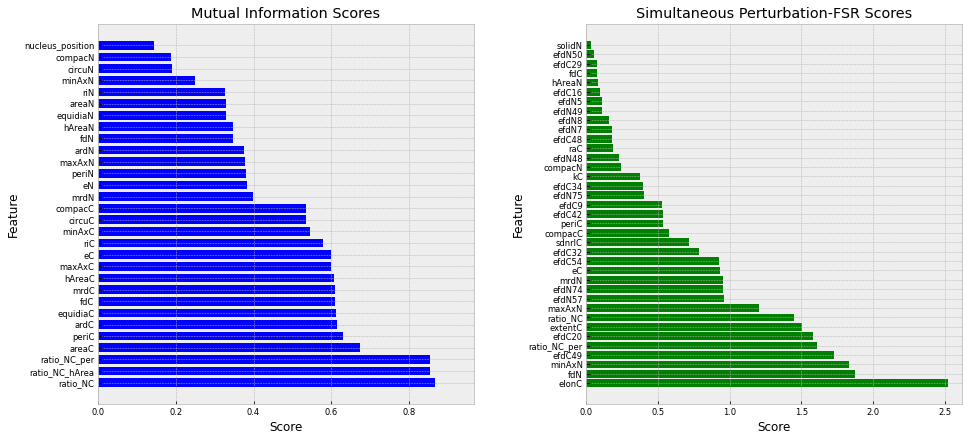

In [197]:
#best_features_spfsr
plot_imp(best_features_MI, feature_importances_MI, 'Mutual Information', 
         best_features_spfsr, feature_importances_spfsr, 'Simultaneous Perturbation-FSR') # 

In [198]:
#Monta base (data_X e data_y):
def get_database_features_filtered(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       features_selected, n_normal=77, n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77,
                       grouped='binary'):

 
    data =  pd.DataFrame(data=np.vstack([
                          data_normal.loc[sample(range(0, data_normal.shape[0]), n_normal)].values,
                          data_ascus.loc[sample(range(0, data_ascus.shape[0]), n_ascus)].values,
                          data_asch.loc[sample(range(0, data_asch.shape[0]), n_asch)].values,
                          data_lsil.loc[sample(range(0, data_lsil.shape[0]), n_lsil)].values, 
                          data_hsil.loc[sample(range(0, data_hsil.shape[0]), n_hsil)].values,
                          data_car.loc[sample(range(0, data_car.shape[0]), n_car)].values]), 
                         columns = data_car.columns)
    image_cells_ids= data[['image_id', 'cell_id']] 

    data_x = np.concatenate([data[best_features_spfsr].values])
    data_y = data['bethesda'].values
    if grouped == 'binary':
        for i in range(data_x.shape[0]):
           data_y[i] = 0 if y[i]==0 else 1
    elif grouped == 'ternary':    
        for i in range(data_x.shape[0]):
          if data_y[i] == 3:  ##Lsil
             data_y[i] = 1
          elif (data_y[i] == 4 or data_y[i] == 5):  ##HSIl e Car
                data_y[i] = 2 
    return data_x, data_y, image_cells_ids

In [199]:
## Monda base para classificação (binária)
data_x, data_y, image_cells_ids= get_database_features_filtered(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       best_features_spfsr, n_normal=(77*5), n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77,
                       grouped='binary')


In [200]:
data_x.shape, data_y.shape, image_cells_ids.shape

((770, 37), (770,), (770, 2))

### Cross-validation:  Normal vs Anormal

In [201]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
lin= 0  ## linha inicial para inclusão no dataframe results
classifiers = ['SVM', 'RF', 'XGBoost']
ci = 0

In [204]:
# Se lected features
#features_selected = fs_indices_mutual_info  
features_desc= str(N_FEATURES)+" features selected by MI"  
N_SPLITS = 10 

# Executa cross-validation e mostra curvas ROC
cv = StratifiedKFold(n_splits= N_SPLITS)

accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
tprs = []
mean_fpr = np.linspace(0, 1, 100)

preds_y = np.zeros_like(data_y)

## Ajusta features para treino e teste
#X = data_x[:,fs_indices_mutual_info]
X = data_x 

model = getModel(classifier = classifiers[ci], class_type = 'binary')
for i, (train, test) in enumerate(cv.split(X, data_y)):
    # Ajusta modelo:
    model.fit(X[train], data_y[train])    
    
    # Predição:
    pred_y = model.predict(X[test])
    prob_y = model.predict_proba(X[test])
    
    #Registra predições:
    preds_y[test] = pred_y
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(data_y[test], pred_y, metric_type='acc')
    precs[i] = calc_metric(data_y[test], pred_y, metric_type='prec')                
    recs[i] = calc_metric(data_y[test], pred_y, metric_type='rec')                
    specs[i] = calc_metric(data_y[test], pred_y, metric_type='spec')                
    f1_scores[i] = calc_metric(data_y[test], pred_y, metric_type='f1_score')                
       
    # Calcula curva_roc e AUC:
    prob = prob_y[:, 1]
    fpr, tpr, thresholds = roc_curve(data_y[test], prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs[i]= auc(mean_fpr, interp_tpr)
                     
## Registra resultados (dataframe):
metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
           'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type='binary')

# Calcula e registra curva ROC (média CV)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
roc_curve_list.append((mean_fpr, mean_tpr))
label = r"Mean ROC (AUC %s= %0.4f $\pm$ %0.4f)" % ((classifiers[ci]+"-binary "), mean_auc, std_auc)
labels_list.append(label)

# Acumula Matrizes de confusão:
conf_matrix_list.append(make_confusionMatrixDisplay(
      data_y, preds_y, labels = [0,1], title=features_desc + "- "+classifiers[ci]))

lin+= 1
ci+= 1                     

# Exibe curva ROC para classificador Binário (cross validation)
def plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve - Normal vs Anormal"):
    fig, ax = plt.subplots(figsize=(9,5))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    for i,color in zip(range(len(roc_curve_list)), colors):
        ax.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            label=labels_list[i],
            lw=2,
            alpha=0.8,
        )
 
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title= title
    )
    ax.legend(loc="lower right")
    plt.show()



In [205]:
len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(3, 3, 3)

### Resultados:

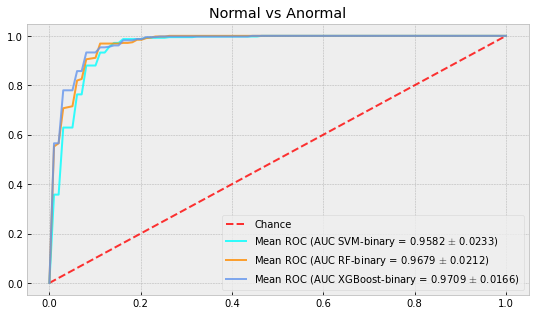

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,binary,SVM,30 features selected by MI,0.9582,0.9582,0.9582,0.0418,0.9582,0.9582
1,binary,RF,30 features selected by MI,0.9679,0.9679,0.9679,0.0321,0.9679,0.9679
2,binary,XGBoost,30 features selected by MI,0.9709,0.9709,0.9709,0.0291,0.9709,0.9709


In [206]:
plot_roc_curve_CV(roc_curve_list, labels_list, title = "Normal vs Anormal")
results


#### Matrizes de confução

<Figure size 432x288 with 0 Axes>

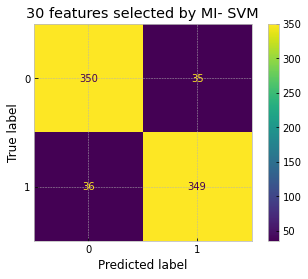

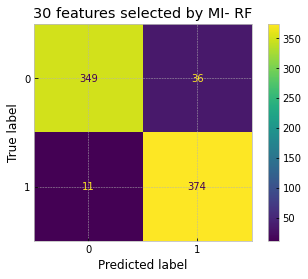

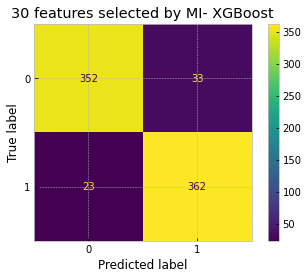

<Figure size 432x288 with 0 Axes>

In [207]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos

### Classificador ternário

In [216]:
# Monta base para classificação (ternária)
data_x, data_y, image_cells_ids= get_database_features_filtered(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       best_features_spfsr, n_normal=154, n_ascus=77,
                       n_lsil=77, n_asch=51, n_hsil=51, n_car=52,
                       grouped='ternary')


In [217]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
lin= 0  ## linha inicial para inclusão no dataframe results
classifiers = ['SVM', 'RF', 'XGBoost']
ci = 0

In [221]:
# Se lected features
#features_selected = fs_indices_mutual_info  
features_desc= str(N_FEATURES)+" features selected by MI"  
N_SPLITS = 10 

# Executa cross-validation e mostra curvas ROC
cv = StratifiedKFold(n_splits= N_SPLITS)

accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
tprs = []
mean_fpr = np.linspace(0, 1, 100)

preds_y = np.zeros_like(data_y)

## Ajusta features para treino e teste
#X = data_x[:,fs_indices_mutual_info]
X = data_x 

model = getModel(classifier = classifiers[ci], class_type = 'multiclass')
for i, (train, test) in enumerate(cv.split(X, data_y)):
    # Ajusta modelo:
    model.fit(X[train], data_y[train])    
    
    # Predição:
    pred_y = model.predict(X[test])
    prob_y = model.predict_proba(X[test])
    
    #Registra predições:
    preds_y[test] = pred_y
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(data_y[test], pred_y, metric_type='acc', class_type = 'multiclass', classes=[0,1,2])
    precs[i] = calc_metric(data_y[test], pred_y, metric_type='prec', class_type = 'multiclass', classes=[0,1,2])                
    recs[i] = calc_metric(data_y[test], pred_y, metric_type='rec', class_type = 'multiclass', classes=[0,1,2])                
    specs[i] = calc_metric(data_y[test], pred_y, metric_type='spec', class_type = 'multiclass', classes=[0,1,2])                
    f1_scores[i] = calc_metric(data_y[test], pred_y, metric_type='f1_score', class_type = 'multiclass', classes=[0,1,2])                
       
## Registra resultados (dataframe):
metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
           'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}      

fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type= "ternary")

# Acumula Matrizes de confusão:
conf_matrix_list.append(make_confusionMatrixDisplay(
      data_y, preds_y, labels = [0,1,2], title=features_desc + "- "+classifiers[ci]))

lin+= 1
ci+= 1                     


In [222]:
 len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(0, 0, 3)

In [223]:
#plot_roc_curve_CV(roc_curve_list, labels_list, title = "Normal vs ASC-US/LSIL vs ASC-H/HSIL/Car")
results


,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,ternary,SVM,30 features selected by MI,0.9013,0.9013,0.9013,0.0987,0.9013,0.9013
1,ternary,RF,30 features selected by MI,0.9323,0.9323,0.9323,0.0677,0.9323,0.9323
2,ternary,XGBoost,30 features selected by MI,0.9237,0.9237,0.9237,0.0763,0.9237,0.9237


<Figure size 432x288 with 0 Axes>

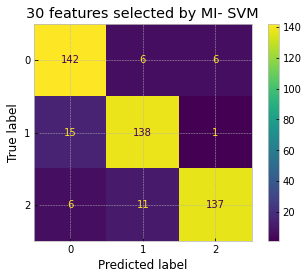

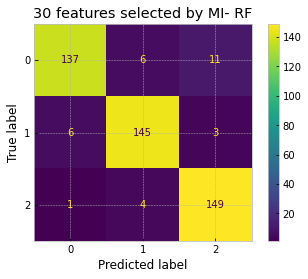

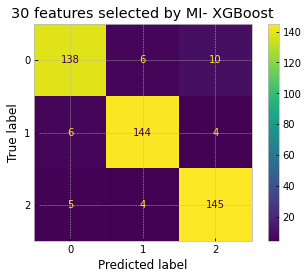

<Figure size 432x288 with 0 Axes>

In [224]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos

### Classificação Bethesda:

In [238]:
# Monta base para classificação (ternária)
data_x, data_y, image_cells_ids= get_database_features_filtered(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       best_features_MI, n_normal=77, n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77,
                       grouped='bethesda')


In [239]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
lin= 0  ## linha inicial para inclusão no dataframe results
classifiers = ['SVM', 'RF', 'XGBoost']
ci = 0

In [242]:
# Se lected features
#features_selected = fs_indices_mutual_info  
features_desc= str(N_FEATURES)+" features selected by MI"  
N_SPLITS = 10 

# Executa cross-validation e mostra curvas ROC
cv = StratifiedKFold(n_splits= N_SPLITS)

accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
tprs = []
mean_fpr = np.linspace(0, 1, 100)

preds_y = np.zeros_like(data_y)

## Ajusta features para treino e teste
#X = data_x[:,fs_indices_mutual_info]
X = data_x 

model = getModel(classifier = classifiers[ci], class_type = 'multiclass')
for i, (train, test) in enumerate(cv.split(X, data_y)):
    # Ajusta modelo:
    model.fit(X[train], data_y[train])    
    
    # Predição:
    pred_y = model.predict(X[test])
    prob_y = model.predict_proba(X[test])
    
    #Registra predições:
    preds_y[test] = pred_y
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(data_y[test], pred_y, metric_type='acc', class_type = 'multiclass', classes=[0,1,2,3,4,5])
    precs[i] = calc_metric(data_y[test], pred_y, metric_type='prec', class_type = 'multiclass', classes=[0,1,2,3,4,5])                
    recs[i] = calc_metric(data_y[test], pred_y, metric_type='rec', class_type = 'multiclass', classes=[0,1,2,3,4,5])                
    specs[i] = calc_metric(data_y[test], pred_y, metric_type='spec', class_type = 'multiclass', classes=[0,1,2,3,4,5])                
    f1_scores[i] = calc_metric(data_y[test], pred_y, metric_type='f1_score', class_type = 'multiclass', classes=[0,1,2,3,4,5])                
       
## Registra resultados (dataframe):
metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
           'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}      

fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type= "ternary")

# Acumula Matrizes de confusão:
conf_matrix_list.append(make_confusionMatrixDisplay(
      data_y, preds_y, labels = [0,1,2], title=features_desc + "- "+classifiers[ci]))

lin+= 1
ci+= 1                     


In [243]:
 len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(0, 0, 3)

In [244]:
results

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,ternary,SVM,30 features selected by MI,0.1188,0.1188,0.1188,0.8812,0.1188,0.1188
1,ternary,RF,30 features selected by MI,0.5791,0.5791,0.5791,0.4209,0.5791,0.5791
2,ternary,XGBoost,30 features selected by MI,0.5753,0.5753,0.5753,0.4247,0.5753,0.5753


In [ ]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos

In [ ]:
# Exibe gráficos boxplot - dist nucleo borda:
fig = plt.figure(figsize =(15, 10))
ax = fig.add_subplot(111)

dist = []
num_samples = 77
for i in Bethesda_idx_classes.keys():
      dist.append(data_x[(0 + i*num_samples):((i+1)*num_samples), 14])

ax.boxplot(dist_to_C_border_cells, labels = ['Normal', 'ASC-US', 'ASC-H', 'LSIL','HSIL', 'Invasive Carcinoma'], patch_artist = True,
                notch ='True') 
ax.set_title("Proximidade do Núcleo da borda (citoplasma)")